- Load libraries
- Get data, including EDA
- Clean, prepare, and manipulate data
- Modeling (train & test)
- Algorithm tuning
- Finalizing the model

## Load libraries

In [0]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import missingno as msno
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler

## Get data, including EDA

In [0]:
# load datasets
# tip: we don't have y_test in kaggle competition
#     X_train,y_train = train
#     X_test = test
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [0]:
train.head()

,host_response_time,host_response_rate,host_neighbourhood,host_listings_count,neighbourhood,city,state,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,reviews_per_month,price
0,within an hour,84%,Ipanema,12.0,Ipanema,Rio De Janeiro,Rj,22411-002,-22.98262,-43.20720,Apartment,Entire home/apt,4,2.0,2.0,2.0,Real Bed,$500.00,$130.00,$23.00,2,1125,21,81.0,0.32,309.0
1,within a day,50%,Barra da Tijuca,1.0,Barra da Tijuca,Barra da Tijuca,Rio de Janeiro,22630-010,-23.01124,-43.32676,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,NaN,NaN,$0.00,1,1125,5,88.0,1.15,351.0
2,within an hour,99%,Ipanema,340.0,Copacabana,Copacabana,Rio de Janeiro,22081-010,-22.98264,-43.19115,Apartment,Entire home/apt,8,3.5,3.0,7.0,Real Bed,"$1,000.00",$190.00,$48.00,4,1125,1,100.0,0.06,398.0
3,within a few hours,100%,Lagoa,7.0,Lagoa,Rio de Janeiro,Rio de Janeiro,22061,-22.97651,-43.19890,Apartment,Entire home/apt,10,3.0,3.0,6.0,Real Bed,"$1,972.00",$498.00,$174.00,3,120,7,94.0,0.13,849.0
4,within a day,75%,Joá,4.0,Joá,Rio de Janeiro,RJ,22611-021,-23.00995,-43.28959,House,Entire home/apt,2,1.5,1.0,2.0,Real Bed,NaN,NaN,$100.00,2,9,1,100.0,0.09,70.0


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 26 columns):
host_response_time      6489 non-null object
host_response_rate      6489 non-null object
host_neighbourhood      6344 non-null object
host_listings_count     8997 non-null float64
neighbourhood           8748 non-null object
city                    8988 non-null object
state                   8990 non-null object
zipcode                 8603 non-null object
latitude                9000 non-null float64
longitude               9000 non-null float64
property_type           9000 non-null object
room_type               9000 non-null object
accommodates            9000 non-null int64
bathrooms               8984 non-null float64
bedrooms                8995 non-null float64
beds                    8994 non-null float64
bed_type                9000 non-null object
security_deposit        5999 non-null object
cleaning_fee            7254 non-null object
extra_people            9000 non-

### EDA for numerical columns

In [0]:
# 9 columns float64, 4 columns int64 = 13 numerical columns
numerical_cols  = train.select_dtypes(["float64","int64"]).columns.to_list()
numerical_train = train[numerical_cols].copy()

In [0]:
numerical_train.head()

,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,reviews_per_month,price
0,12.0,-22.98262,-43.20720,4,2.0,2.0,2.0,2,1125,21,81.0,0.32,309.0
1,1.0,-23.01124,-43.32676,2,1.0,1.0,1.0,1,1125,5,88.0,1.15,351.0
2,340.0,-22.98264,-43.19115,8,3.5,3.0,7.0,4,1125,1,100.0,0.06,398.0
3,7.0,-22.97651,-43.19890,10,3.0,3.0,6.0,3,120,7,94.0,0.13,849.0
4,4.0,-23.00995,-43.28959,2,1.5,1.0,2.0,2,9,1,100.0,0.09,70.0


host_listings_count      3
latitude                 0
longitude                0
accommodates             0
bathrooms               16
bedrooms                 5
beds                     6
minimum_nights           0
maximum_nights           0
number_of_reviews        0
review_scores_rating     0
reviews_per_month        1
price                    0
dtype: int64

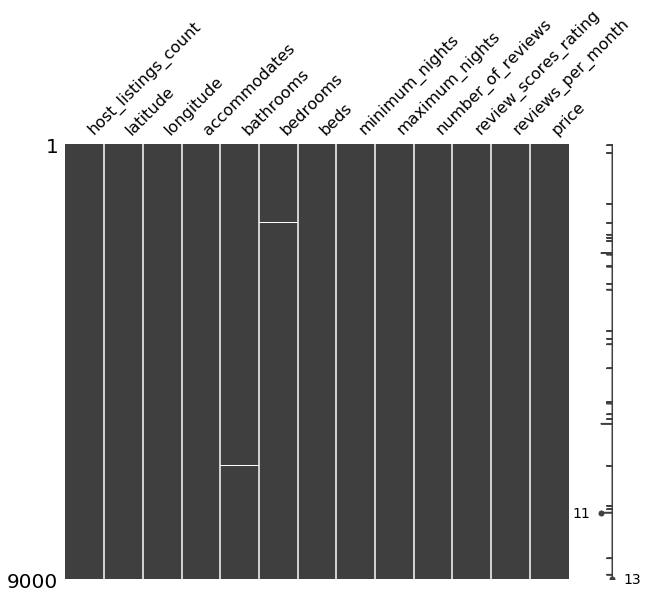

In [0]:
# who is missing?
msno.matrix(numerical_train,figsize=(10,8))
numerical_train.isnull().sum()

In [0]:
numerical_train.describe()

,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,reviews_per_month,price
count,8997.000000,9000.000000,9000.000000,9000.000000,8984.000000,8995.000000,8994.000000,9000.000000,9000.000000,9000.000000,9000.000000,8999.000000,9000.000000
mean,9.105591,-22.966473,-43.233905,3.980111,1.563947,1.514619,2.500334,3.587556,661.760444,15.352000,94.323333,0.610770,367.890000
std,37.763230,0.031795,0.083452,2.267514,0.855437,0.963927,1.891312,17.968985,1584.354138,28.800757,9.774358,0.827369,966.137214
min,0.000000,-23.072620,-43.706640,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,20.000000,0.010000,0.000000
25%,1.000000,-22.984172,-43.230123,2.000000,1.000000,1.000000,1.000000,2.000000,30.000000,2.000000,93.000000,0.100000,131.000000
50%,2.000000,-22.971590,-43.193475,4.000000,1.000000,1.000000,2.000000,2.000000,1125.000000,4.000000,98.000000,0.280000,208.000000
75%,3.000000,-22.953230,-43.184848,5.000000,2.000000,2.000000,3.000000,3.000000,1125.000000,14.000000,100.000000,0.770000,374.000000
max,340.000000,-22.751700,-43.104620,16.000000,9.000000,13.000000,30.000000,1095.000000,99999.000000,341.000000,100.000000,8.280000,35501.000000


**Insights**
- host_listings_count
  - **std** is desproportionate (maybe outliers?)
  - probably imputer using **median**, check again after outlier are removed
- lat, long: 
  - **throw away** for reasons of simplicity
- accommodates: ok
- bathrooms:
  - imputer using **median**
- bedrooms:
  - imputer using **median**
- beds:
  - imputer using **median**
- minimum nights,maximum_nights,number_of_reviews:
  - **std** is desproportionate (maybe outliers?)
- review_scores_rating: ok
- reviews_per_month:
  - **std** is desproportionate (maybe outliers?)
  - imputer using **median**
- **price**:
- **std** is desproportionate (maybe outliers?)

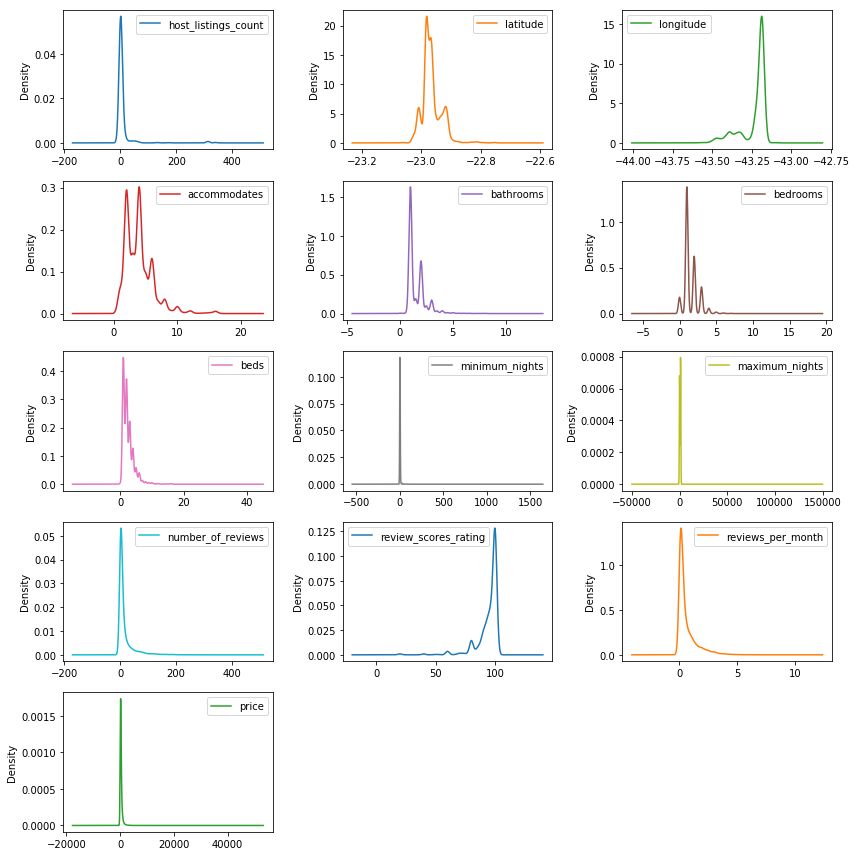

In [0]:
# trying to confirm the insights
numerical_train.plot(kind="density",
          subplots=True,
          sharex=False,
          layout=(5,3),
          figsize=(12,12))
plt.tight_layout()
plt.show()

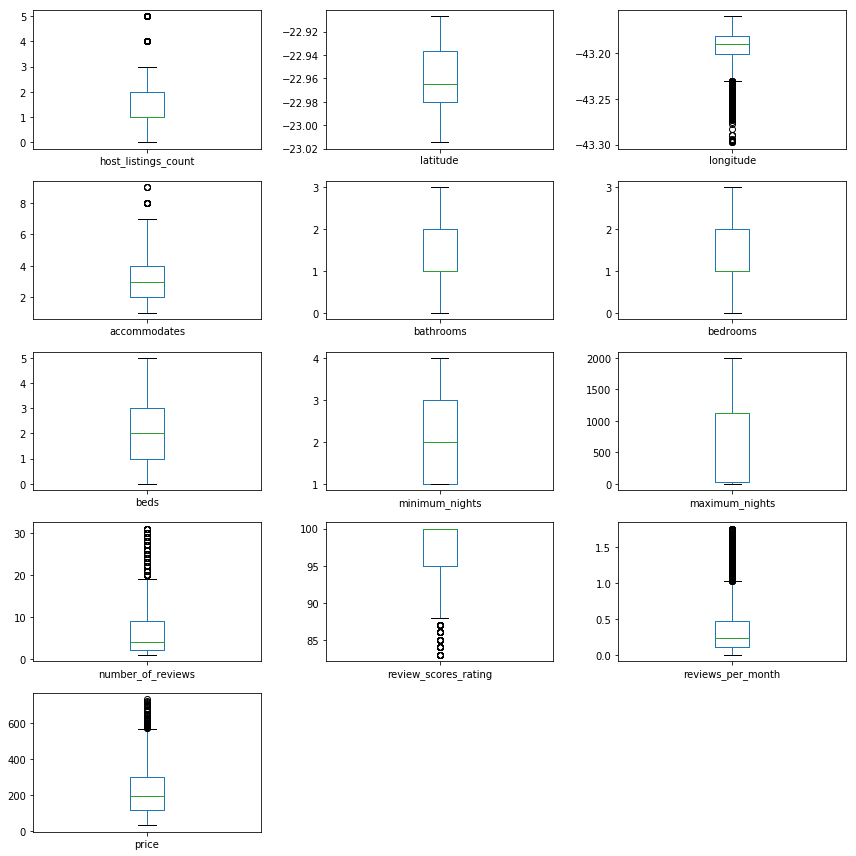

In [0]:
# trying to confirm the insights
numerical_train.plot(kind="box",
                     subplots=True,
                     sharex=False,
                     layout=(5,3),
                     figsize=(12,12))
plt.tight_layout()
plt.show()

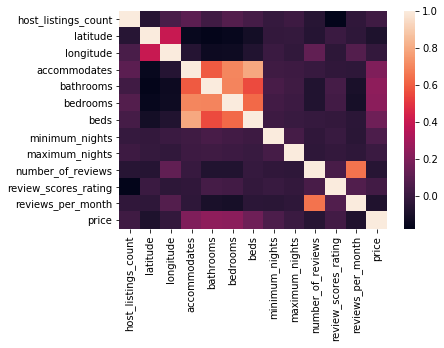

In [0]:
sns.heatmap(numerical_train.corr())

In [0]:
# there is no significant correlation with target column
numerical_train.corr()["price"].sort_values(ascending=False)

price                   1.000000
bathrooms               0.242736
bedrooms                0.236029
accommodates            0.201935
beds                    0.157388
minimum_nights          0.061752
review_scores_rating    0.028816
host_listings_count     0.021250
maximum_nights          0.007182
longitude              -0.016096
number_of_reviews      -0.051673
reviews_per_month      -0.077585
latitude               -0.079550
Name: price, dtype: float64

In [0]:
# columns with correlations between [0.061,-0.079] are condidate to leave
numerical_train.loc[:,(numerical_train.corr()["price"] > 0.062)].columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price'], dtype='object')

In [0]:
# colinearity problem
numerical_train.corr()["accommodates"].sort_values(ascending=False)[:5]

accommodates    1.000000
beds            0.795496
bedrooms        0.702192
bathrooms       0.594450
price           0.201935
Name: accommodates, dtype: float64

In [0]:
def clean_outliers(data, algorithm='iqr'):
  df = data.copy()
  if algorithm == "iqr":
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    up = Q3 + 1.5 * IQR
    df = df[((df > low).all(axis=1) & (df < up).all(axis=1))]
  elif algorithm == "z-score":
    df = pd.DataFrame(StandardScaler().fit_transform(df),
                            columns=df.columns,
                            index=df.index)
    df = df[(df < 2.698).all(axis=1) & (df > -2.698).all(axis=1)]
  return df

In [0]:
df = clean_outliers(numerical_train)

In [0]:
df.shape

(3131, 13)

**Summarization notes**
- outliers can matters
- eliminate columns with small (< 0.06) correlation to target (price)
- normalization can be used
- multicolinearity issues

### EDA for categorical columns

In [0]:
# 9 "object" columns
categorical_cols  = train.select_dtypes(["object"]).columns.to_list()
categorical_train = train[categorical_cols].copy()

In [0]:
categorical_train.head()

,host_response_time,host_response_rate,host_neighbourhood,neighbourhood,city,state,zipcode,property_type,room_type,bed_type,security_deposit,cleaning_fee,extra_people
0,within an hour,84%,Ipanema,Ipanema,Rio De Janeiro,Rj,22411-002,Apartment,Entire home/apt,Real Bed,$500.00,$130.00,$23.00
1,within a day,50%,Barra da Tijuca,Barra da Tijuca,Barra da Tijuca,Rio de Janeiro,22630-010,Apartment,Entire home/apt,Real Bed,NaN,NaN,$0.00
2,within an hour,99%,Ipanema,Copacabana,Copacabana,Rio de Janeiro,22081-010,Apartment,Entire home/apt,Real Bed,"$1,000.00",$190.00,$48.00
3,within a few hours,100%,Lagoa,Lagoa,Rio de Janeiro,Rio de Janeiro,22061,Apartment,Entire home/apt,Real Bed,"$1,972.00",$498.00,$174.00
4,within a day,75%,Joá,Joá,Rio de Janeiro,RJ,22611-021,House,Entire home/apt,Real Bed,NaN,NaN,$100.00


host_response_time    2511
host_response_rate    2511
host_neighbourhood    2656
neighbourhood          252
city                    12
state                   10
zipcode                397
property_type            0
room_type                0
bed_type                 0
security_deposit      3001
cleaning_fee          1746
extra_people             0
dtype: int64

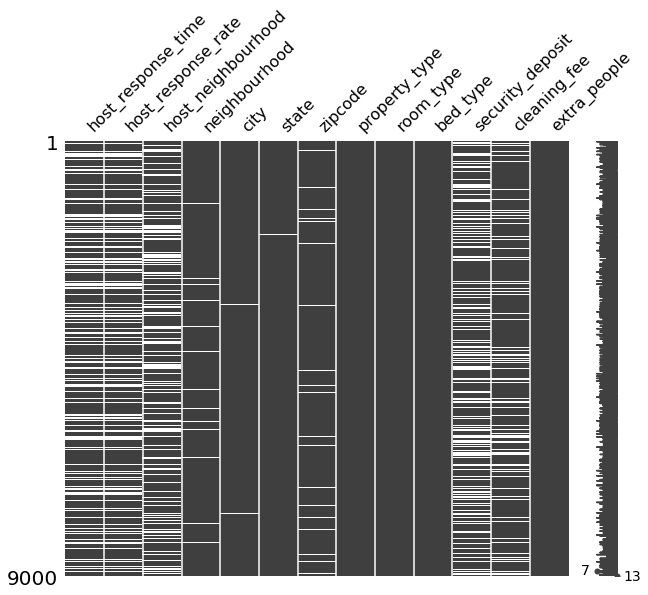

In [0]:
# who is missing?
msno.matrix(categorical_train,figsize=(10,8))
categorical_train.isnull().sum()

In [0]:
# zipcode can be used to identify the neighourhood when the latter is missing
categorical_train[categorical_train.neighbourhood.isnull()].head()

,host_response_time,host_response_rate,host_neighbourhood,neighbourhood,city,state,zipcode,property_type,room_type,bed_type,security_deposit,cleaning_fee,extra_people
44,within a few hours,100%,NaN,NaN,Jacarepagua,Rio de Janeiro,22775-033,Condominium,Entire home/apt,Real Bed,$0.00,$150.00,$0.00
46,NaN,NaN,Barra da Tijuca,NaN,Rio de Janeiro,Rio de Janeiro,21920-001,Apartment,Entire home/apt,Real Bed,$700.00,$130.00,$50.00
117,within a few hours,100%,NaN,NaN,Campo Grande,Rio de Janeiro,23070-470,House,Entire home/apt,Real Bed,NaN,$100.00,$50.00
131,NaN,NaN,NaN,NaN,Rio de Janeiro,Rio de Janeiro,20531,House,Entire home/apt,Real Bed,NaN,NaN,$0.00
132,within an hour,100%,NaN,NaN,"Rio de Janeiro, Rio de Janeiro, BR",RJ,NaN,House,Private room,Real Bed,$0.00,$58.00,$42.00


In [0]:
# investigate missings values on neighbourhood column
# majority come from west zones
categorical_train.loc[categorical_train.neighbourhood.isnull(),["neighbourhood","zipcode"]].zipcode.str[:5].value_counts()

22780    62
22641    13
21931    12
22785    12
22783    10
22770     9
21940     9
22750     8
22765     7
22753     6
22740     6
22745     6
21920     5
21941     5
20397     5
22755     5
22710     4
21321     4
22730     4
22743     3
22775     3
20531     3
22720     3
22725     2
23090     2
22723     2
23055     2
21930     2
23070     2
23093     1
21820     1
20396     1
22531     1
42833     1
23575     1
21810     1
21833     1
23026     1
23545     1
23050     1
22790     1
23020     1
23035     1
21320     1
20535     1
21932     1
23017     1
22713     1
22711     1
2104-     1
22760     1
22735     1
21741     1
Name: zipcode, dtype: int64

In [0]:
categorical_train.describe()

,host_response_time,host_response_rate,host_neighbourhood,neighbourhood,city,state,zipcode,property_type,room_type,bed_type,security_deposit,cleaning_fee,extra_people
count,6489,6489,6344,8748,8988,8990,8603,9000,9000,9000,5999,7254,9000
unique,4,67,94,75,127,27,1795,29,3,5,331,251,187
top,within an hour,100%,Copacabana,Copacabana,Rio de Janeiro,Rio de Janeiro,22050-002,Apartment,Entire home/apt,Real Bed,$0.00,$150.00,$0.00
freq,3194,4183,2190,2736,5275,7947,112,7049,6517,8855,2433,1264,4380


In [0]:
pd.crosstab(categorical_train.property_type,categorical_train.neighbourhood)

In [0]:
pd.crosstab(categorical_train.bed_type,categorical_train.room_type)

room_type,Entire home/apt,Private room,Shared room
bed_type,,,
Airbed,3,6,2
Couch,6,0,2
Futon,14,13,0
Pull-out Sofa,49,46,4
Real Bed,6445,2252,158


In [0]:
categorical_train.bed_type.value_counts()

Real Bed         8855
Pull-out Sofa      99
Futon              27
Airbed             11
Couch               8
Name: bed_type, dtype: int64

In [0]:
categorical_train.room_type.value_counts()

Entire home/apt    6517
Private room       2317
Shared room         166
Name: room_type, dtype: int64

In [0]:
categorical_train.property_type.value_counts()

Apartment                 7049
House                      624
Condominium                457
Serviced apartment         303
Loft                       212
Bed and breakfast           60
Guest suite                 55
Hostel                      39
Guesthouse                  37
Townhouse                   33
Aparthotel                  33
Other                       19
Villa                       17
Boutique hotel              14
Hotel                       14
Chalet                       6
Tiny house                   5
Earth house                  5
Cottage                      3
Nature lodge                 3
Bungalow                     2
Cabin                        2
Boat                         2
Farm stay                    1
Barn                         1
Dorm                         1
Treehouse                    1
Castle                       1
Casa particular (Cuba)       1
Name: property_type, dtype: int64

In [0]:
south = ["Copacabana","Ipanema","Leblon","Botafogo","Flamengo","Leme","Laranjeiras","Glória",
         "Catete","Lagoa","Jardim Botânico","Gávea","Humaitá","São Conrado","Vidigal",
         "Urca","Cosme Velho","Rocinha"]
central = ["Santa Teresa","Centro","Lapa","São Cristóvão","Rio Comprido","Estacio",
           "Gamboa","Cidade Nova","Santo Cristo","Mangueira","Benfica","Saúde",
           "Catumbi","Caju"]
west = ["Barra da Tijuca","Recreio dos Bandeirantes","Barra de Guaratiba","Joá"]
north = ["Tijuca","Maracanã","Vila Isabel","Grajaú","Praça da Bandeira","Andaraí","Engenho Novo",
         "Engenho de Dentro","Del Castilho","Todos os Santos","Marechal Hermes","Penha",
         "Irajá", "Cachambi", "Rocha","Brás de Pina", "Cascadura", "Bento Ribeiro","Maria da Graça",
         "Inhaúma","Méier","Quintino Bocaiúva","Sampaio","Pilares","Madureira","Parada de Lucas",
         "Guadalupe","Lins de Vasconcelos","Coelho Neto","Engenho da Rainha","Encantado",
         "Tomás Coelho","Penha Circular","Parque Anchieta","Piedade","Oswaldo Cruz","Complexo de Alemão",
         "Riachuelo","Vincente de Carvalho"]

In [0]:
categorical_train.neighbourhood.value_counts()

**insights**
- remove columns with missings values greater than 1,000
- **city, state** make no sense in this problem
- remains: **neighbourhood, property_type, room_type, bed_type, extra_people**
- **bed_type** can be split into "Real Bed" and "Other".
- **extra_people** can be manipulate in order to transfom into a numerical column
- **neighbourhood**: maybe handle neighbourhood organized in zones/regions (north, west, east, south)?
- **property_type**: size less or equal than 60 can be classified as "Other"

## Clean, prepare, and manipulate data

In [0]:
# Pipeline
# Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self.feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[self.feature_names ] 

In [0]:
# validation
# model_fs = FeatureSelector (numerical_cols2)
# model_fs.fit_transform(train)

### Numerical columns

In [0]:
# columns with correlations between [0.061,-0.079] are condidate to leave
# filter all of them
numerical_cols2 = numerical_train.loc[:,(numerical_train.corr()["price"] > 0.062)].columns.to_list()
numerical_train2 = train[numerical_cols2]
numerical_train2.head()

,accommodates,bathrooms,bedrooms,beds,price
0,4,2.0,2.0,2.0,309.0
1,2,1.0,1.0,1.0,351.0
2,8,3.5,3.0,7.0,398.0
3,10,3.0,3.0,6.0,849.0
4,2,1.5,1.0,2.0,70.0


In [0]:
numerical_train2.describe()

,accommodates,bathrooms,bedrooms,beds,price
count,9000.000000,8984.000000,8995.000000,8994.000000,9000.000000
mean,3.980111,1.563947,1.514619,2.500334,367.890000
std,2.267514,0.855437,0.963927,1.891312,966.137214
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,131.000000
50%,4.000000,1.000000,1.000000,2.000000,208.000000
75%,5.000000,2.000000,2.000000,3.000000,374.000000
max,16.000000,9.000000,13.000000,30.000000,35501.000000


**insight**
- the std is not so discrepant when compared with mean

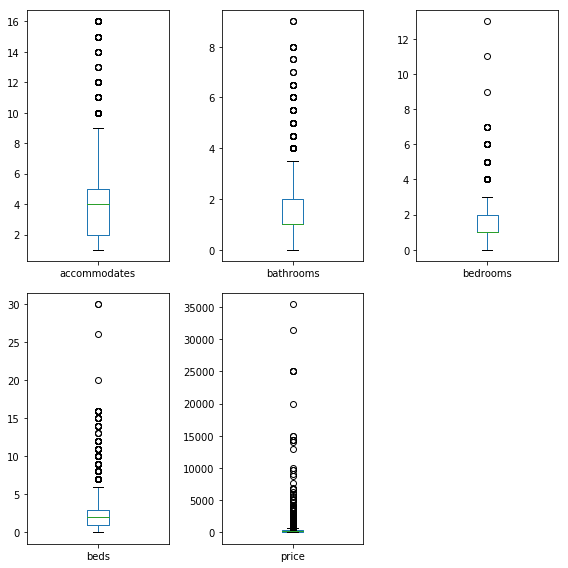

In [0]:
# trying to confirm the insights
numerical_train2.plot(kind="box",
          subplots=True,
          sharex=False,
          layout=(2,3),
          figsize=(8,8))
plt.tight_layout()
plt.show()

In [0]:
# Create an imputer object
mean_imputer = SimpleImputer(strategy='median',missing_values=np.nan)

# Train the imputer on the numerical train dataset
median_imputer = mean_imputer.fit(numerical_train2)

numerical_train2_imputered = pd.DataFrame(median_imputer.transform(numerical_train2), columns=numerical_cols2)

In [0]:
# before
numerical_train2.describe()

,accommodates,bathrooms,bedrooms,beds,price
count,9000.000000,8984.000000,8995.000000,8994.000000,9000.000000
mean,3.980111,1.563947,1.514619,2.500334,367.890000
std,2.267514,0.855437,0.963927,1.891312,966.137214
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,131.000000
50%,4.000000,1.000000,1.000000,2.000000,208.000000
75%,5.000000,2.000000,2.000000,3.000000,374.000000
max,16.000000,9.000000,13.000000,30.000000,35501.000000


In [0]:
# after
numerical_train2_imputered.describe()

,accommodates,bathrooms,bedrooms,beds,price
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,3.980111,1.562944,1.514333,2.500000,367.890000
std,2.267514,0.855006,0.963736,1.890725,966.137214
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,131.000000
50%,4.000000,1.000000,1.000000,2.000000,208.000000
75%,5.000000,2.000000,2.000000,3.000000,374.000000
max,16.000000,9.000000,13.000000,30.000000,35501.000000


In [0]:
numerical_train2_imputered.corr()

,accommodates,bathrooms,bedrooms,beds,price
accommodates,1.000000,0.593107,0.702202,0.795354,0.201935
bathrooms,0.593107,1.000000,0.698517,0.556225,0.242685
bedrooms,0.702202,0.698517,1.000000,0.630427,0.236072
beds,0.795354,0.556225,0.630427,1.000000,0.157373
price,0.201935,0.242685,0.236072,0.157373,1.000000


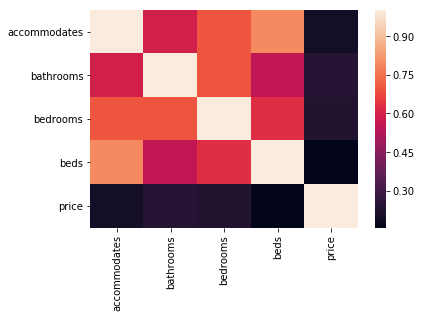

In [0]:
sns.heatmap(numerical_train2_imputered.corr())

**insights**
- multicolinearity problem
  - [0,strong] accommodates, bathrooms, bedrooms, bed 
  - [1,high] accommodates, bathrooms, bedrooms
  - [2,small] bathrooms, bed
  - [3,no] bathrooms
  - [4,no] bedrooms



In [0]:
# Select what numerical column will be used
class NumericalFeatureSelection( BaseEstimator, TransformerMixin ):
  #Class constructor method that takes a scenario as its argument
  def __init__(self, scenario=0):
    self.scenario = scenario

  #Return self nothing else to do here    
  def fit( self, X, y = None ):
    return self 
        
  #Transformer method we wrote for this transformer 
  def transform(self, X , y = None ):
    df = X.copy()
    if self.scenario == 0:
      return df
    elif self.scenario == 1:
      return df[["accommodates", "bathrooms", "bedrooms"]]
    elif self.scenario == 2:
      return df[["bathrooms","beds"]]
    elif self.scenario == 3:
      return df["bathrooms"].values.reshape(-1,1)
    else:
      return df["bedrooms"].values.reshape(-1,1)

In [0]:
# validation

# first pipeline - select all numerical columns
# model_fs = FeatureSelector (numerical_cols2)
# only_numerical_df = model_fs.fit_transform(train)

# second pipeline - select specific numerical columns
# model_fs_scenario = NumericalFeatureSelection(scenario=4)
# model_fs_scenario.fit_transform(only_numerical_df).head()

### Numerical Columns Pipeline

In [0]:
# Numerical features to pass down the numerical pipeline 
numerical_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds']

# Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(numerical_features)),
                                       ('scenario_selector', NumericalFeatureSelection(4)),
                                       ('imputer_num',SimpleImputer(strategy='median')) 
                                       ]
                              )

In [0]:
# validation
# numerical_pipeline.fit_transform(train)

### Categorical Columns

In [0]:
categorical_cols2 = ["neighbourhood", "property_type", "room_type", "bed_type", "extra_people"]
categorical_train2 = train[categorical_cols2].copy()

In [0]:
categorical_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 5 columns):
neighbourhood    8748 non-null object
property_type    9000 non-null object
room_type        9000 non-null object
bed_type         9000 non-null object
extra_people     9000 non-null object
dtypes: object(5)
memory usage: 351.6+ KB


In [0]:
categorical_train2.head()

,neighbourhood,property_type,room_type,bed_type,extra_people
0,Ipanema,Apartment,Entire home/apt,Real Bed,$23.00
1,Barra da Tijuca,Apartment,Entire home/apt,Real Bed,$0.00
2,Copacabana,Apartment,Entire home/apt,Real Bed,$48.00
3,Lagoa,Apartment,Entire home/apt,Real Bed,$174.00
4,Joá,House,Entire home/apt,Real Bed,$100.00


#### bed_type

In [0]:
# bed_type can be split into "Real Bed" and "Other".
categorical_train2.loc[categorical_train2.bed_type != "Real Bed","bed_type"] = "Other"

In [0]:
pd.concat([categorical_train2.bed_type,numerical_train2.price],axis=1).groupby(by="bed_type").agg(["mean",np.std])

price            
                mean         std
bed_type                        
Other     216.806897  229.457400
Real Bed  370.363975  973.381377

In [0]:
categorical_train2.bed_type.value_counts()

Real Bed    8855
Other        145
Name: bed_type, dtype: int64

In [0]:
# drop=first is to avoid colinearity
OneHotEncoder(sparse=False,drop="first").fit_transform(categorical_train2.bed_type.values.reshape(-1,1))

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [0]:
#pd.get_dummies(categorical_train2.bed_type,drop_first=True)["Real Bed"].value_counts()
pd.get_dummies(categorical_train2.bed_type,drop_first=True).head()

,Real Bed
0,1
1,1
2,1
3,1
4,1


In [0]:
categorical_train2 = pd.concat([categorical_train2,pd.get_dummies(categorical_train2.bed_type,drop_first=True)],axis=1)
categorical_train2.drop(labels="bed_type",axis=1,inplace=True)
categorical_train2.head()

,neighbourhood,property_type,room_type,extra_people,Real Bed
0,Ipanema,Apartment,Entire home/apt,$23.00,1
1,Barra da Tijuca,Apartment,Entire home/apt,$0.00,1
2,Copacabana,Apartment,Entire home/apt,$48.00,1
3,Lagoa,Apartment,Entire home/apt,$174.00,1
4,Joá,House,Entire home/apt,$100.00,1


In [0]:
categorical_train2["Real Bed"].value_counts()

1    8855
0     145
Name: Real Bed, dtype: int64

#### extra_people

In [0]:
# extra_people can be manipulate in order to transfom into a numerical column
stripped_commas = categorical_train2.extra_people.str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
categorical_train2['extra_people'] = stripped_dollars.astype('float')

In [0]:
categorical_train2.head()

,neighbourhood,property_type,room_type,extra_people,Real Bed
0,Ipanema,Apartment,Entire home/apt,23.0,1
1,Barra da Tijuca,Apartment,Entire home/apt,0.0,1
2,Copacabana,Apartment,Entire home/apt,48.0,1
3,Lagoa,Apartment,Entire home/apt,174.0,1
4,Joá,House,Entire home/apt,100.0,1


In [0]:
# extra_people has a low correlation with other numerical columns, mainly with our target :-/
pd.concat([numerical_train2,categorical_train2.extra_people],axis=1).corr()

,accommodates,bathrooms,bedrooms,beds,price,extra_people
accommodates,1.000000,0.594450,0.702192,0.795496,0.201935,0.109855
bathrooms,0.594450,1.000000,0.698749,0.555973,0.242736,0.141599
bedrooms,0.702192,0.698749,1.000000,0.630546,0.236029,0.129180
beds,0.795496,0.555973,0.630546,1.000000,0.157388,0.106595
price,0.201935,0.242736,0.236029,0.157388,1.000000,0.085368
extra_people,0.109855,0.141599,0.129180,0.106595,0.085368,1.000000


#### neighbourhood

In [0]:
south = ["Copacabana","Ipanema","Leblon","Botafogo","Flamengo","Leme","Laranjeiras","Glória",
         "Catete","Lagoa","Jardim Botânico","Gávea","Humaitá","São Conrado","Vidigal",
         "Urca","Cosme Velho","Rocinha"]
central = ["Santa Teresa","Centro","Lapa","São Cristóvão","Rio Comprido","Estacio",
           "Gamboa","Cidade Nova","Santo Cristo","Mangueira","Benfica","Saúde",
           "Catumbi","Caju"]
west = ["Barra da Tijuca","Recreio dos Bandeirantes","Barra de Guaratiba","Joá"]
north = ["Tijuca","Maracanã","Vila Isabel","Grajaú","Praça da Bandeira","Andaraí","Engenho Novo",
         "Engenho de Dentro","Del Castilho","Todos os Santos","Marechal Hermes","Penha",
         "Irajá", "Cachambi", "Rocha","Brás de Pina", "Cascadura", "Bento Ribeiro","Maria da Graça",
         "Inhaúma","Méier","Quintino Bocaiúva","Sampaio","Pilares","Madureira","Parada de Lucas",
         "Guadalupe","Lins de Vasconcelos","Coelho Neto","Engenho da Rainha","Encantado",
         "Tomás Coelho","Penha Circular","Parque Anchieta","Piedade","Oswaldo Cruz","Complexo de Alemão",
         "Riachuelo","Vincente de Carvalho"]

In [0]:
def mapping_zones(neigh):
  if neigh in south:
    return "south"
  elif (neigh in central):
    return "central"
  elif neigh in north:
    return "north"
  else:
    # west and south have similar mean
    return "south"

In [0]:
categorical_train2["zones"] = categorical_train2.neighbourhood.map(mapping_zones)

In [0]:
categorical_train2.zones.value_counts()

south      7915
central     682
north       403
Name: zones, dtype: int64

In [0]:
categorical_train2.neighbourhood.value_counts().head()

Copacabana         2736
Barra da Tijuca    1261
Ipanema            1035
Leblon              522
Botafogo            488
Name: neighbourhood, dtype: int64

In [0]:
pd.concat([categorical_train2.zones,numerical_train2.price],axis=1).groupby(by="zones").agg(["mean",np.std])

price             
               mean          std
zones                           
central  184.227273   248.557134
north    255.841191  1768.168368
south    389.420467   945.122313

In [0]:
categorical_train2 = pd.concat([categorical_train2,pd.get_dummies(categorical_train2.zones,drop_first=True)],axis=1)
categorical_train2.drop(labels=["neighbourhood","zones","extra_people"],axis=1,inplace=True)
categorical_train2.head()

,property_type,room_type,Real Bed,north,south
0,Apartment,Entire home/apt,1,0,1
1,Apartment,Entire home/apt,1,0,1
2,Apartment,Entire home/apt,1,0,1
3,Apartment,Entire home/apt,1,0,1
4,House,Entire home/apt,1,0,1


#### room_type


In [0]:
categorical_train2.room_type.value_counts()

Entire home/apt    6517
Private room       2317
Shared room         166
Name: room_type, dtype: int64

In [0]:
pd.concat([categorical_train2.room_type,numerical_train2.price],axis=1).groupby(by="room_type").agg(["mean",np.std])

price             
                       mean          std
room_type                               
Entire home/apt  442.127666  1091.840381
Private room     178.019422   464.294616
Shared room      103.572289   102.387577

In [0]:
categorical_train2 = pd.concat([categorical_train2,pd.get_dummies(categorical_train2.room_type,drop_first=True)],axis=1)
categorical_train2.drop(labels=["room_type"],axis=1,inplace=True)
categorical_train2.head()

,property_type,Real Bed,north,south,Private room,Shared room
0,Apartment,1,0,1,0,0
1,Apartment,1,0,1,0,0
2,Apartment,1,0,1,0,0
3,Apartment,1,0,1,0,0
4,House,1,0,1,0,0


#### property_type

In [0]:
# size less or equal than 460 can be classified as "Other"
series_property = categorical_train2.property_type.value_counts()
# filter types
target_types = series_property[(series_property <= 460) | (series_property == 7049)].index.to_list()
# change the values for "Other" in case less or equal 460
categorical_train2.loc[categorical_train2.property_type.isin(target_types),"property_type"] = "Other"

In [0]:
series_property.head(10)

Apartment    7049
Other        1327
House         624
Name: property_type, dtype: int64

In [0]:
categorical_train2.property_type.value_counts()

Other    8376
House     624
Name: property_type, dtype: int64

In [0]:
pd.concat([categorical_train2.property_type,numerical_train2.price],axis=1).groupby(by="property_type").agg(["mean",np.std])

price             
                     mean          std
property_type                         
House          448.415064  1737.235805
Other          361.890998   882.012780

In [0]:
categorical_train2 = pd.concat([categorical_train2,pd.get_dummies(categorical_train2.property_type,drop_first=True)],axis=1)
categorical_train2.drop(labels=["property_type"],axis=1,inplace=True)
categorical_train2.head()

,Real Bed,north,south,Private room,Shared room,Other
0,1,0,1,0,0,1
1,1,0,1,0,0,1
2,1,0,1,0,0,1
3,1,0,1,0,0,1
4,1,0,1,0,0,0


### Categorical columns pipeline

In [0]:
def mapping_zones(neigh):
    if neigh in south:
      return "south"
    elif neigh in central:
      return "central"
    elif neigh in north:
      return "north"
    else:
      return "south"

south = ["Copacabana","Ipanema","Leblon","Botafogo","Flamengo","Leme","Laranjeiras","Glória",
         "Catete","Lagoa","Jardim Botânico","Gávea","Humaitá","São Conrado","Vidigal",
         "Urca","Cosme Velho","Rocinha"]
central = ["Santa Teresa","Centro","Lapa","São Cristóvão","Rio Comprido","Estacio",
           "Gamboa","Cidade Nova","Santo Cristo","Mangueira","Benfica","Saúde",
           "Catumbi","Caju"]
west = ["Barra da Tijuca","Recreio dos Bandeirantes","Barra de Guaratiba","Joá"]
north = ["Tijuca","Maracanã","Vila Isabel","Grajaú","Praça da Bandeira","Andaraí","Engenho Novo",
         "Engenho de Dentro","Del Castilho","Todos os Santos","Marechal Hermes","Penha",
         "Irajá", "Cachambi", "Rocha","Brás de Pina", "Cascadura", "Bento Ribeiro","Maria da Graça",
         "Inhaúma","Méier","Quintino Bocaiúva","Sampaio","Pilares","Madureira","Parada de Lucas",
         "Guadalupe","Lins de Vasconcelos","Coelho Neto","Engenho da Rainha","Encantado",
         "Tomás Coelho","Penha Circular","Parque Anchieta","Piedade","Oswaldo Cruz","Complexo de Alemão",
         "Riachuelo","Vincente de Carvalho"]


In [0]:
# Preprocessing Categorical Columns
class CategoricalPreprocessing(BaseEstimator, TransformerMixin):

  #Class constructor method that takes a boolean as its argument
  def __init__(self, scenario=0):
    self.scenario = scenario

  #Return self nothing else to do here    
  def fit( self, X, y = None):
    return self 
        
  #Transformer method we wrote for this transformer 
  def transform(self, X , y = None):
    df = X.copy()

    # bed_type
    # bed_type can be split into "Real Bed" and "Other"
    df.loc[df.bed_type != "Real Bed","bed_type"] = "Other"
    # dummify the column and concatenate with df
    df = pd.concat([df,pd.get_dummies(df.bed_type,drop_first=True)],axis=1)

    # neighbourhood
    # transform neigh info into zones
    df["zones"] = df.neighbourhood.map(mapping_zones)
    # dummify the column and concatenate with df
    df = pd.concat([df,pd.get_dummies(df.zones,drop_first=True)],axis=1)

    # room_type
    # dummify the column and concatenate with df
    df = pd.concat([df,pd.get_dummies(df.room_type,drop_first=True)],axis=1)

    # property_tye
    # size less or equal than 460 can be classified as "Other"
#    series_property = df.property_type.value_counts()
    # filter types
#    target_types = series_property[(series_property <= 460) | (series_property == 7049)].index.to_list()
    # change the values for "Other" in case less or equal 460
#    df.loc[df.property_type.isin(target_types),"property_type"] = "Other"
    # dummify the column and concatenate with df
#    df = pd.concat([df,pd.get_dummies(df.property_type,drop_first=True)],axis=1)

    # drop original columns
    df.drop(labels=["bed_type","neighbourhood","zones",
                    "extra_people","room_type","property_type"],
            axis=1,inplace=True)
    return df

In [0]:
# Preprocessing Categorical Columns
class CategoricalPreprocessingNoDummy(BaseEstimator, TransformerMixin):

  #Class constructor method that takes a boolean as its argument
  def __init__(self, scenario=0):
    self.scenario = scenario

  #Return self nothing else to do here    
  def fit( self, X, y = None):
    return self 
        
  #Transformer method we wrote for this transformer 
  def transform(self, X , y = None):
    df = X.copy()

    # bed_type
    # bed_type can be split into "Real Bed" and "Other"
    df.loc[df.bed_type != "Real Bed","bed_type"] = "Other"
  
    # neighbourhood
    # transform neigh info into zones
    df["zones"] = df.neighbourhood.map(mapping_zones)
    
    # room_type
    
    # property_tye
    # size less or equal than 460 can be classified as "Other"
    series_property = df.property_type.value_counts()
    # filter types
    target_types = series_property[(series_property <= 460) | (series_property == 7049)].index.to_list()
    # change the values for "Other" in case less or equal 460
    df.loc[df.property_type.isin(target_types),"property_type"] = "Other"

    # drop original columns
    df.drop(labels=["neighbourhood","extra_people"],
            axis=1,inplace=True)
   
    # convert columns to categorical
    for name in df.columns.to_list():
      col = pd.Categorical(df[name])
      df[name] = col.codes
    return df

In [0]:
# validation
categorical_features = ['neighbourhood', 'property_type', 
                        'room_type', 'bed_type', 'extra_people']
cat_fs = CategoricalPreprocessing()
cat_fs.transform(train[categorical_features])

In [0]:
# validation 2
cat_fs2 = CategoricalPreprocessingNoDummy()
cat_fs2.transform(train[categorical_features])

,property_type,room_type,bed_type,zones
0,1,0,1,2
1,1,0,1,2
2,1,0,1,2
3,1,0,1,2
4,0,0,1,2
5,0,1,1,1
6,1,1,1,0
7,1,0,1,2
8,1,0,1,2
9,1,1,1,2


## Modeling (train & test)

In [0]:
df = clean_outliers(train[['accommodates', 'bathrooms', 'bedrooms', 'beds']])
df.shape

(8153, 4)

In [0]:
# Train
X_train = train.loc[df.index,:].drop(labels="price",axis=1)
y_train = train.loc[df.index,"price"]

# Test
X_test = test

In [0]:
# Categrical features 
categorical_features = ['neighbourhood', 'property_type', 'room_type', 'bed_type', 'extra_people']
# Numerical features 
numerical_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds']

# Defining the steps in the categorical pipeline     
categorical_pipeline = Pipeline(steps = [('cat_selector', FeatureSelector(categorical_features)),
                                       ('cat_prep', CategoricalPreprocessingNoDummy())#CategoricalPreprocessing()) 
                                       ]
                              )
# Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(numerical_features)),
                                       ('scenario_selector', NumericalFeatureSelection()),
                                       ('imputer_num',SimpleImputer(strategy='median')) 
                                       ]
                              )
# Combining numerical and categorical piepline into one full big pipeline horizontally 
# using FeatureUnion
full_pipeline_preprocessing = FeatureUnion(transformer_list = [('categorical_pipeline', categorical_pipeline),
                                                               ('numerical_pipeline', numerical_pipeline)
                                                               ]
                                           )

## Algorithm Tuning

In [0]:
seed = 42
num_folds = 5
scoring = 'neg_mean_squared_error'

# The full pipeline as a step in another pipeline with an estimator as the final step
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("fs",SelectKBest()),
                         ("regressor",KNeighborsRegressor())])

# create a dictionary with the hyperparameters
search_space = [
                {"regressor":[KNeighborsRegressor()],
                 "regressor__n_neighbors": [10,20,30],
                 "fs__k":[4,6,8]
                 },
                {"regressor":[LinearRegression()],
                 "regressor__fit_intercept":[False,True],
                 "fs__k":[4,6,8]
                 }
                ]

# create grid search
kfold = KFold(n_splits=num_folds,random_state=seed)

# return_train_score=True
# official documentation: "computing the scores on the training set can be
# computationally expensive and is not strictly required to
# select the parameters that yield the best generalization performance".
grid = GridSearchCV(estimator=pipe, 
                    param_grid=search_space,
                    cv=kfold,
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1)

# fit grid search
best_model = grid.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
result = pd.DataFrame(best_model.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fs__k,param_regressor,param_regressor__n_neighbors,param_regressor__fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.125746,0.004554,0.070909,0.001683,4,"KNeighborsRegressor(algorithm='auto', leaf_siz...",10,NaN,"{'fs__k': 4, 'regressor': KNeighborsRegressor(...",-992429.130582,-135299.162121,-554036.009957,-1.913833e+06,-953718.877988,-909734.769386,590434.926413,15,-850151.209109,-1.085617e+06,-971842.762810,-606143.959575,-859382.604584,-874627.512304,159299.902260
1,0.124784,0.008929,0.085207,0.017987,4,"KNeighborsRegressor(algorithm='auto', leaf_siz...",20,NaN,"{'fs__k': 4, 'regressor': KNeighborsRegressor(...",-957983.254132,-85295.714801,-524866.361576,-1.916880e+06,-932859.185436,-883444.154599,606861.136402,9,-847848.270553,-1.056995e+06,-950548.235395,-604726.715884,-844534.184749,-860930.453602,150035.285981
2,0.122379,0.003364,0.081028,0.001726,4,"KNeighborsRegressor(algorithm='auto', leaf_siz...",30,NaN,"{'fs__k': 4, 'regressor': KNeighborsRegressor(...",-940073.046447,-73166.813649,-529160.214991,-1.911034e+06,-921970.037867,-874948.004555,606982.871893,7,-841388.557938,-1.055882e+06,-951607.033229,-605938.978112,-844404.409299,-859844.214515,149598.217240
3,0.116840,0.004694,0.089244,0.006311,6,"KNeighborsRegressor(algorithm='auto', leaf_siz...",10,NaN,"{'fs__k': 6, 'regressor': KNeighborsRegressor(...",-928240.322164,-103410.745365,-522850.735169,-1.925240e+06,-930199.155282,-881854.339489,604612.288695,8,-814203.716881,-1.028774e+06,-922256.779364,-602473.283324,-820986.828048,-837738.927126,141295.533699
4,0.118619,0.004870,0.100209,0.004966,6,"KNeighborsRegressor(algorithm='auto', leaf_siz...",20,NaN,"{'fs__k': 6, 'regressor': KNeighborsRegressor(...",-955323.017316,-122514.850561,-527012.087673,-1.929098e+06,-924081.823919,-891474.750328,600952.008162,12,-868432.153133,-1.056034e+06,-937839.660674,-596989.687360,-830482.339069,-857955.473957,151383.007710
5,0.116306,0.003467,0.105948,0.001553,6,"KNeighborsRegressor(algorithm='auto', leaf_siz...",30,NaN,"{'fs__k': 6, 'regressor': KNeighborsRegressor(...",-922014.683538,-131560.038337,-523094.928407,-1.932615e+06,-918830.184764,-885490.419759,599737.356246,10,-848580.173637,-1.062872e+06,-940804.137418,-598711.209635,-834422.821917,-857078.117612,152774.478274
6,0.120532,0.001854,0.102404,0.001959,8,"KNeighborsRegressor(algorithm='auto', leaf_siz...",10,NaN,"{'fs__k': 8, 'regressor': KNeighborsRegressor(...",-933803.858204,-155157.275684,-578373.631429,-1.925203e+06,-934878.083270,-905354.476970,585024.040070,14,-822359.543332,-1.071228e+06,-933340.909131,-600504.879902,-824956.872418,-850477.947517,154612.518427
7,0.120626,0.004550,0.120679,0.007718,8,"KNeighborsRegressor(algorithm='auto', leaf_siz...",20,NaN,"{'fs__k': 8, 'regressor': KNeighborsRegressor(...",-976963.907735,-111999.123668,-535953.307097,-1.947891e+06,-927655.421804,-899960.588851,609593.380654,13,-856840.237492,-1.048150e+06,-934643.613429,-598269.519877,-836611.963956,-854903.109385,148257.956584
8,0.117106,0.002352,0.131798,0.004871,8,"KNeighborsRegressor(algorithm='auto', leaf_siz...",30,NaN,"{'fs__k': 8, 'regressor': KNeighborsRegressor(...",-949982.767091,-106996.210938,-529948.115488,-1.935571e+06,-925568.375241,-889480.668698,606727.920956,11,-842801.724440,-1.052885e+06,-935066.569923,-594345.723352,-842936.321487,-853607.157379,150860.590066
9,0.136744,0.042438,0.028847,0.000898,4,"LinearRegression(copy_X=True, fit_intercept=Tr...",NaN,False,"{'fs__k': 4, 'regressor': LinearRegression(cop...",-925341.115894,-70314.469458,-514996.138955,-1.907524e+06,-909428.263685,-865387.656194,607665.037943,2,-848800.910003,-1.062816e+06,-951572.053475,-603819.332790,-852847.672588,-863971.232017

In [0]:
# Training score much higher than test score.
# The standard deviation of the test score is large.
result_train = result[['mean_train_score', 'std_train_score','mean_test_score', 'std_test_score']].copy()
result_train.loc[:,['mean_train_score','mean_test_score']] *= -1
np.sqrt(result_train)

,mean_train_score,std_train_score,mean_test_score,std_test_score
0,935.215222,399.123918,953.800173,768.397636
1,927.863381,387.343886,939.917100,779.012924
2,927.277852,386.779288,935.386554,779.091055
3,915.280791,375.892982,939.070998,777.568189
4,926.258859,389.079693,944.179406,775.210944
5,925.785136,390.863759,941.005005,774.427115
6,922.213613,393.207984,951.501170,764.868642
7,924.609707,385.042798,948.662526,780.764613
8,923.908630,388.407763,943.122828,778.927417
9,929.500528,389.640474,930.262144,779.528728


## Prepare submission

In [0]:
# prepare a submission file
submission_df = {"id": test.index, "price": best_model.predict(X_test)}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission.csv",index=False)

In [0]:
files.download("submission.csv")